In [3]:
import pandas as pd
import numpy as np
import datetime
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [4]:
filename = "data.csv"
#import and clean data
nRowsRead = None
data = pd.read_csv(filename, delimiter = ',', nrows = nRowsRead, na_values=['', 'N/A', 'CA'])

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (29,30,31,32,38) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
# helper functions

''' 
A function that converts a date in the format given by data into a datetime object
:param d: - a date as a string (assuming uniform formatting)
:return: the date as a Date namedtuple
'''
def convert_date(d):
    # considering format 'dd/mm/yyyy hh:mm'
    date = d.split(' ')[0].split('/')
    time = d.split(' ')[1].split(':')
    return datetime.datetime(int(date[2]), int(date[1]), int(date[0]), int(time[0]), int(time[1]))

'''
A function that calculates the difference between two datetime objects, in minutes
:param earlier: datetime object representing earlier of the two times
:param later: datetime object representing later of the two times
:return: the difference in the two times, in minutes
'''
def calc_time_diff(earlier,later):
    delta = later - earlier
    return delta.days*1440.0 + delta.seconds/60.0

'''
A function that returns a list of interarrival times from data
:param data: a list of times at which cars arrived at a charging station
:param peak_list: a list with entry 1 if corresponding hour is a peak hour, 0 o.w.
:return: the interarrival times given by the input data
'''
def interarrival_calc(data, peak_map):
    peak_durs = []
    non_peak_durs = []
    pairs = list(zip(data[0:-1],data[1:]))
    for p in pairs:
        diff = calc_time_diff(p[0],p[1])
        if peak_map[p[0].hour] and peak_map[p[1].hour]: 
#             print("peak: " + str(diff))
            peak_durs.append(diff)
        else: 
#             print("non-peak: " + str(diff))
            non_peak_durs.append(diff)
    return peak_durs, non_peak_durs

In [9]:
uniq_stations = set(data["Station Name"])
num_stations = len(uniq_stations)
name_to_id = dict(zip(list(uniq_stations),range(num_stations)))
id_to_name = dict(zip(range(num_stations), list(uniq_stations)))
station_ids = np.zeros(data.shape[0], dtype=np.int8)
month_year = []
start_dates = []

station_dict = {}
station_ids = []

for i,row in data.iterrows():
    if row['Station Name'] not in station_dict.keys():
        #get number of station for ID and add to list of stations
        station_id = len(station_dict.keys())
        station_dict[row['Station Name']] = station_id
    else: 
        val = station_dict[row['Station Name']]
    station_ids.append(station_id)
    month_year.append((row["Year"], row["Month"]))
    sd = row["Start Date"]
    start_dates.append(convert_date(sd))
data["Station ID"] = station_ids
data["Month/Year"] = month_year
data["Start Date (dt)"] = start_dates

dates = list(set(data["Month/Year"]))
num_months = len(set(data["Month/Year"]))

In [10]:
# calculate probability of arrival for each station in each hour
distribution_matrix = np.zeros((num_stations, 24))
for i in range(num_stations):
    station_data = data.loc[data["Station ID"] == i]
    get_hour = lambda d: d.hour
    
    hour_data = station_data["Start Date (dt)"].apply(get_hour)
    station_freq = station_data.shape[0]
    
    for h in range(24):  
        distribution_matrix[i,h] = np.sum(hour_data == h)
    distribution_matrix[i] = distribution_matrix[i]/station_freq

# learn optimal separation between peak and non-peak hours
kmeans = KMeans(2, random_state=69).fit(distribution_matrix.T)
peak_mapping = kmeans.predict(distribution_matrix.T) # 1 indicates peak time, 0 indicates non-peak

In [11]:
sorted_dates = sorted(dates,key=(lambda d: (d[0],d[1])))
rate_params_peak = np.full((num_stations,num_months), -1.0)
rate_params_nonpeak = np.full((num_stations,num_months), -1.0)

calc_lambda = lambda d: np.mean(d) if len(d) > 0 else -1

for i in range(num_stations): # iterating over stations
    # isolating samples associated with specific station
    station_data = data.loc[data["Station ID"] == i] 
    for j,date in enumerate(sorted_dates): # iterating over months
        station_data_month = station_data.loc[data["Month/Year"] == date]
        if station_data_month.shape[0] > 0: 
            times = list(station_data_month["Start Date (dt)"])
            peak, non_peak = interarrival_calc(times, peak_mapping)
            rate_params_peak[i,j] = calc_lambda(np.array(peak))
            rate_params_nonpeak[i,j] = calc_lambda(np.array(non_peak))

In [12]:
print(rate_params_peak[0]) # checking output

[-1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.
 -1.]


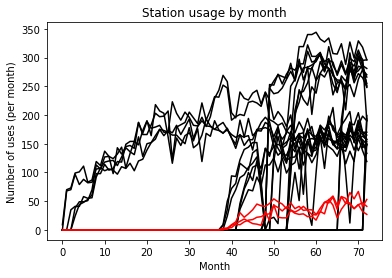

In [155]:
# trying to figure out what is up with these whack stations!

s = [4, 7, 11]
for i in range(num_stations):
    if i not in s:
        sd = data.loc[data["Station ID"] == i]
        date_count = {}
        for i,sample in sd.iterrows():
            date = sample["Month/Year"]
            if date in date_count.keys():
                date_count[date] += 1
            else: 
                date_count[date] = 1

        counts = [date_count[d] if d in date_count.keys() else 0 for d in sorted_dates]
        plt.plot(range(num_months), counts, color='black')


for i in s:
    sd = data.loc[data["Station ID"] == i]
    date_count = {}
    for i,sample in sd.iterrows():
        date = sample["Month/Year"]
        if date in date_count.keys():
            date_count[date] += 1
        else: 
            date_count[date] = 1
        
    counts = [date_count[d] if d in date_count.keys() else 0 for d in sorted_dates]
    plt.plot(range(num_months), counts, color='red')
    
plt.title('Station usage by month')
plt.xlabel('Month')
plt.ylabel('Number of uses (per month)')
plt.show()